NOTE: DEZE CODE IS NOG NIET VOLLEDIG. We willen twee hoeken ($\theta$ en $\varphi$) meten met behulp van een tweetal microfoons op dezelfde rij ($\theta$) een een tweetal op dezelfde kolom ($\varphi$), terwijl deze code je maar één hoek geeft op basis van één paar. De code voor beide hoeken is identiek, maar er moeten nog kleine aanpassingen worden gemaakt in het tweede deel van de code.

TOEGEVOEGDE NOTE: Vermoedelijk zit er een fout in dtime bepalen. Verder doet de code wat hij moet doen (behalve dat de waarde niet in het domein van arccos zit, maar dat komt door de fout in dtime). Check github onzecode/toevoeging.jpg voor extra informatie.

De code bestaat uit twee delen. Het eerste deel doet de meting en alle setup. Het tweede deel berekend de hoeken. Onderscheid tussen de delen is gemaakt zodat we niet een aparte meting hoeven te doen per hoek. We hebben op deze manier genoeg aan één meting.

DEEL 1: Run onderstaande code om een meting te doen. Pas de geluidssnelheid (v) en de afstanden tussen de microfoons (d) onderin dit code-blok aan zoals gewenst. 

In [13]:
#>>>>FINDING AUDIO DEVICE
import sounddevice as sd
from picamera2 import Picamera2
import time
import os

camera = None

def initialize_camera():
    global camera
    camera = Picamera2()
    config = camera.create_still_configuration()
    # config["main"]["size"] = (4608, 2592)
    config["main"]["size"] = (1920, 1440)
    camera.configure(config)

def capture_image(filename: str):
    filepath = os.path.expanduser(filename)
    print("capturing image", filepath)
    camera.start()
    time.sleep(0.5)
    camera.capture_file(filepath)
    camera.stop()
    camera.close()

# everloop.set(ledsgreen)
initialize_camera()

capture_image("savedimage.jpg")

indev = sd.query_devices("UMA16v2")
print(f"Found input device {indev}")

#>>>>>SETTINGS
freq = 44000 #frequency
nchan = 16 #number of channels
sd.default.samplerate = freq
sd.default.channels = nchan
sd.default.device = 1 #this can be different. print sd.query_devices() to check.

#>>>>>RECORD
import numpy as np

npt = 440000 #total number of measurements per channel (TIME * FREQ)
dur = npt/freq

print(">>> Start recording for %5.2fs (%d samples per channel)" % (dur,npt))
rec = sd.rec(npt)
sd.wait()
untransposed = np.array(rec)
arec = np.transpose(untransposed) #<<-- THIS IS OUR DATA
np.save( 'data_voorthuis',arec)
print(">>> Done (%s x %s samples)" % (str(np.shape(arec)[0]), str(np.shape(arec)[1])))

Found input device {'name': 'UMA16v2: USB Audio (hw:2,0)', 'index': 1, 'hostapi': 0, 'max_input_channels': 16, 'max_output_channels': 2, 'default_low_input_latency': 0.008684807256235827, 'default_low_output_latency': 0.008684807256235827, 'default_high_input_latency': 0.034829931972789115, 'default_high_output_latency': 0.034829931972789115, 'default_samplerate': 44100.0}
>>> Start recording for 10.00s (440000 samples per channel)
>>> Done (16 x 440000 samples)


In [7]:
#>>>>FINDING AUDIO DEVICE
#import sounddevice as sd

#indev = sd.query_devices("UMA16v2")
#print(f"Found input device {indev}")

#>>>>>SETTINGS
#freq = 44000 #frequency
#nchan = 16 #number of channels
#sd.default.samplerate = freq
#sd.default.channels = nchan
#sd.default.device = 1 #this can be different. print sd.query_devices() to check.

#>>>>>RECORD
#import numpy as np

#npt = 220000 #total number of measurements per channel (TIME * FREQ)
#dur = npt/freq

#print(">>> Start recording for %5.2fs (%d samples per channel)" % (dur,npt))
#rec = sd.rec(npt)
#sd.wait()
#untransposed = np.array(rec)
#arec = np.transpose(untransposed) #<<-- THIS IS OUR DATA
#print(">>> Done (%s x %s samples)" % (str(np.shape(arec)[0]), str(np.shape(arec)[1])))

import matplotlib.pyplot as plt


#APPLYING FILTER
import scipy.signal as sps

def BandpassFilter(samples, freq, center_freq, width, order=5):
    nyquist = freq / 2
    low  = (center_freq - width/2) / nyquist
    high = (center_freq + width/2) / nyquist
    b, a = sps.butter(order, [low, high], btype='band')
    return sps.filtfilt(b, a, samples)

outsmp = np.zeros((16, npt))
for i in range(0, 16):
    outsmp[i, :] = BandpassFilter(arec[i, :], freq, 1911, 100) #outsmp is the filtered data!

#CALCULATING THE TIME DIFFERENCE
def time_difference(mic1index, mic2index, arec, freq): #<<-- use 1-index
    #difference in datapoints
    
    maxmic1 = max(arec[mic1index - 1])
    dp1 = np.where(arec[mic1index - 1] == maxmic1)[0][0]
    maxmic2 = max(arec[mic2index - 1])
    dp2 = np.where(arec[mic2index - 1] == maxmic2)[0][0]
    dpd = dp1 - dp2 #<<-- NOTE1 THE SIGNIFICANE OF THE SIGN!
    plt.figure('1')
    plt.plot(arec[4,:])
    plt.xlim(dp2-1000,dp1+1000)
    #plt.plot(arec[4,(dp1-50):(dp1+50)])
    plt.plot(dp1,arec[4,dp1], 'ro')
    plt.plot(arec[11,:]+0.01)
    plt.plot(dp2,arec[11,dp2] +0.01,'bo')
    plt.show()
    
    #plt.figure('2')
    #plt.plot(arec[4,:])
    #plt.xlim(dp1-1000,dp2+1000)
    #plt.plot(dp1,arec[4,dp1], 'ro')
    #plt.plot(arec[11,:]+0.01)
    #plt.plot(dp2,arec[11,dp2] +0.01,'bo')
    #plt.show()

    plt.figure('3')
    plt.plot(arec[4,:])
    plt.plot(arec[11,:]+0.01)
    plt.plot(dp1,arec[4,dp1], 'ro')
    plt.plot(dp2,arec[11,dp2] +0.01,'bo')
    plt.show()
    #time difference
    dtime = dpd/freq
    #print(arec[4,(dp1-50):(dp1+50)])
    return dtime

def time_diference_som(mic1index, mic2index, arec, freq):
    signal1 = arec[6, :]  + arec[4, :] + arec[2, :] + arec[0, :]
    signal2 =  arec[9, :] + arec[11, :] + arec[13, :] + arec[15, :]

        
    maxmic1 = max(arec[mic1index - 1])
    dp1 = np.where(arec[mic1index - 1] == maxmic1)[0][0]
    maxmic2 = max(arec[mic2index - 1])
    dp2 = np.where(arec[mic2index - 1] == maxmic2)[0][0]
    dpd = dp1 - dp2 #<<-- NOTE1 THE SIGNIFICANE OF THE SIGN!


    
#CALCULATING THE ANGLE
import math 

def angle(mic1index, mic2index, arec, freq):
    v = 342.55 #speed of sound (m/s)
    d = 0.042 #distance between mics (m)
    print(time_difference(mic1index, mic2index, arec, freq))
    print((v * time_difference(mic1index, mic2index, arec, freq))/d)
    theta = math.acos((v * time_difference(mic1index, mic2index, arec, freq))/d)
    
    return theta

from PIL import Image, ImageDraw

def determine_pcoord(xangle, yangle):
    x_coord = (138270 * (xangle - math.pi/2))/(17 * math.pi) + 2304
    y_coord = 1269 - (466560 * (yangle - math.pi/2))/(67 * math.pi)
    return (x_coord, y_coord)

def cross(xangle, yangle, xerr, yerr):
    image = Image.open('savedimage.jpg')

    #convert everything to pixels.
    right = determine_pcoord(xangle + xerr, yangle)
    left = determine_pcoord(xangle - xerr, yangle)
    high = determine_pcoord(xangle, yangle + yerr)
    low = determine_pcoord(xangle, yangle - yerr)

    #drawing the cross
    draw.line([left, right], fill = 'red', width = 3)
    draw.line([high, low], fill = 'red', width = 3)
    draw.line([(left[0], left[1] + 5), (left[0], left[1] - 5)], fill = 'red', width = 3)
    draw.line([(right[0], right[1] + 5), (right[0], right[1] - 5)], fill = 'red', width = 3)
    draw.line([(high[0] + 5, high[1]), (high[0] - 5, high[1])], fill = 'red', width = 3)
    draw.line([(low[0] + 5, low[1]), (low[0] - 5, low[1])], fill = 'red', width = 3)
    
    image.save('finalpicture.png')


DEEL 2: Pas "EERSTE_MIC" en "TWEEDE_MIC" aan. Merk op dat de volgorde uitmaakt voor de interpretatie van de hoek. Lees hiervoor de comment onderin de code.

HORIZONTAAL: Kies voor "EERSTE_MIC_h" en "TWEEDE_MIC_h" twee microfoons die in dezelfde rij liggen.

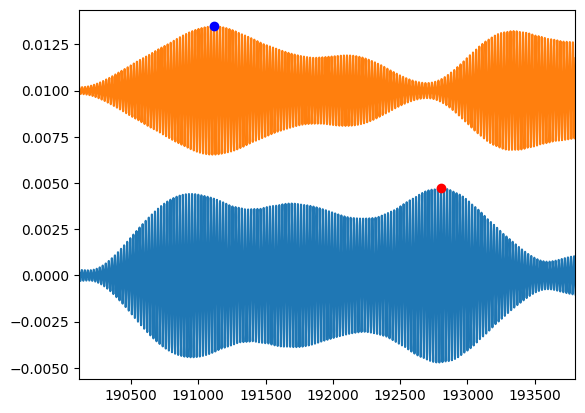

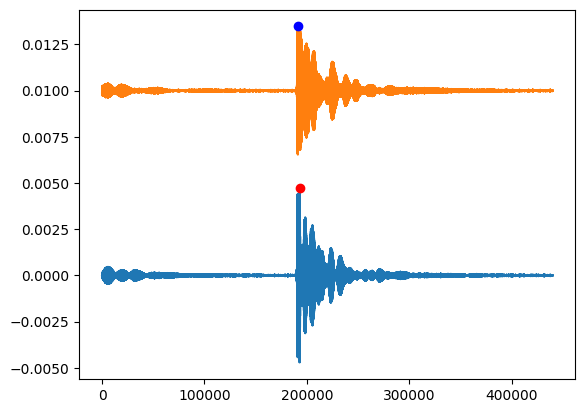

0.038363636363636364


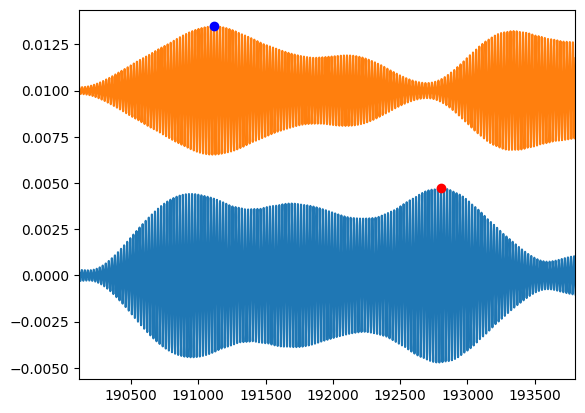

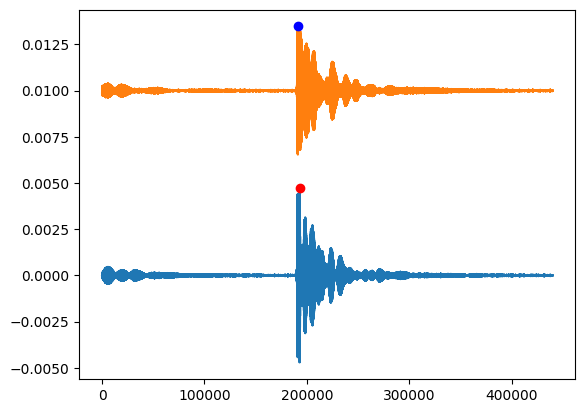

312.89199134199134


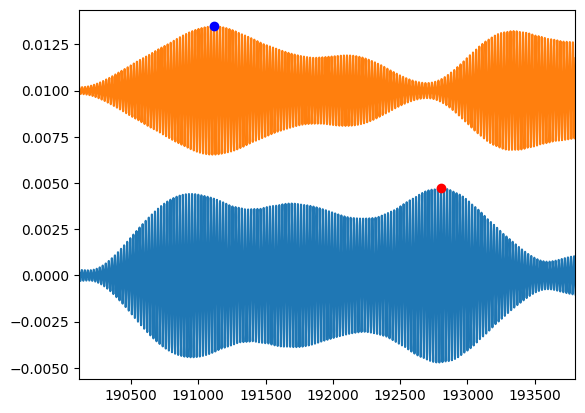

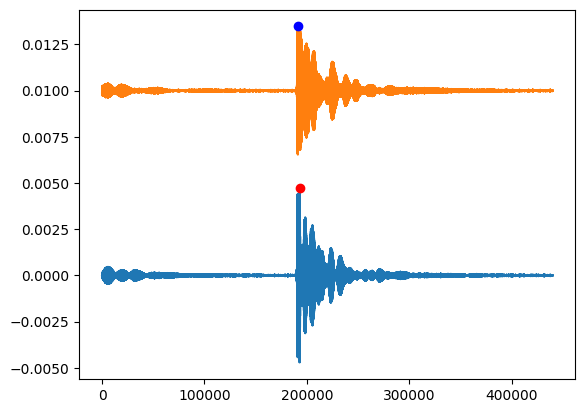

ValueError: math domain error

In [11]:
EERSTE_MIC_h = 5 #in 1-index
TWEEDE_MIC_h = 12 #in 1-index


theta = angle(EERSTE_MIC_h, TWEEDE_MIC_h, outsmp, freq)

print("Deze hoek is ", theta, " radialen.")

#>>>>>>NOTEEEEEE: An angle theta should be interpreted as follows:
#Draw a line between "EERSTE_MIC" and "TWEEDE_MIC". Rotate that line with *output* radians over "EERSTE_MIC". The line will point towards the source.


VERTICAAL: Kies voor "EERSTE_MIC_v" en "TWEEDE_MIC_v" twee microfoons die in dezelfde kolom liggen.

In [ ]:
EERSTE_MIC_v = 5 #in 1-index
TWEEDE_MIC_v = 7 #in 1-index

phi = angle(EERSTE_MIC_h, TWEEDE_MIC_h, outsmp, freq)

print("Deze hoek is ", phi, " radialen.")

#>>>>>>NOTEEEEEE: An angle theta should be interpreted as follows:
#Draw a line between "EERSTE_MIC" and "TWEEDE_MIC". Rotate that line with *output* radians over "EERSTE_MIC". The line will point towards the source.

In [ ]:
cross()